In [114]:
import pandas as pd
import glob
# All files and directories ending with .txt and that don't begin with a dot:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
# !pip install tweet-preprocessor
import preprocessor as p
import spacy
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
warnings.filterwarnings('ignore')

In [2]:
data2 = pd.read_csv("Clean_1st.csv")
# data2 = data2.sample(n=1000)

In [3]:
#This function is used to tokenize the tweets and remove the stop words which may not be useful for analysis
from nltk.tokenize import TweetTokenizer
nlp=spacy.load('en_core_web_sm')
tokenizer = TweetTokenizer()

data3 = data2[data2["Post Type"] == 'Original']
# data3['clean_soundbite'] = data3['Sound Bite Text'] #***********to delete************
textData = []
for items in data3['clean_soundbite']:
    textData.append(items)

token_list = []
tokenizedData = []
for data in textData:
    cleaned = [word.lower() for word in tokenizer.tokenize(data.lower()) if word not in nlp.Defaults.stop_words and len(word) > 2]
    tokenizedData.append(' '.join(cleaned))
    token_list.extend(cleaned)

In [4]:
data3['iphone x'] = 0
data3['iphone 8'] = 0
data3['galaxy'] = 0
data3["tokenizedData"] = tokenizedData
for i in data3['Sound Bite Text'].index:
    if re.search(r'iphone[\s]*x', data3['tokenizedData'][i].lower()):
        data3['iphone x'][i] = 1
    if re.search(r'iphone[\s]*8', data3['tokenizedData'][i].lower()):
        data3['iphone 8'][i] = 1
    if re.search(r'galaxy[\s]*s8', data3['tokenizedData'][i].lower()):
        data3['galaxy'][i] = 1

In [5]:
x = 0 #iphone x only tweets
i8 = 0 #iphone 8 only tweets
g = 0 #galaxy only tweets
for i in data3['tokenizedData'].index:
    if data3['iphone x'][i] == 1 and data3['iphone 8'][i] == 0 and data3['galaxy'][i] == 0:
        x+=1
    if data3['iphone x'][i] == 0 and data3['iphone 8'][i] == 1 and data3['galaxy'][i] == 0:
        i8+=1
    if data3['iphone x'][i] == 0 and data3['iphone 8'][i] == 0 and data3['galaxy'][i] == 1:
        g+=1
        

print(x, i8, g)

2360 14874 22602


In [6]:
iphone_x = data3[(data3['iphone x'] == 1) & (data3['iphone 8'] == 0) & (data3['galaxy']==0)]
iphone_8 = data3[(data3['iphone x'] == 0) & (data3['iphone 8'] == 1) & (data3['galaxy']==0)]
galaxy = data3[(data3['iphone x'] == 0) & (data3['iphone 8'] == 0) & (data3['galaxy']==1)]

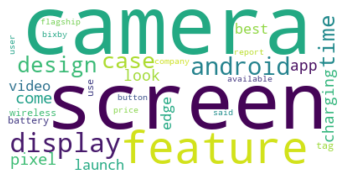

In [7]:
del_words = ["latest", "free", "mobile","iphone", "galaxy", "samsung", "plus", "apple", "new", "phone", "device", "smartphone", "year", "model", "google", "note"]

text = " ".join(str(review) for review in token_list if not any(word in str(review) for word in del_words))
wordcloud = WordCloud(background_color="white", collocations=False, max_words=30).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
combined_adjs = []
combined_nouns = []
def pos_tag(tokenized):
    adjs = []
    nouns = []
    for tweet in tokenized['tokenizedData']:
        for i in nlp(tweet):
            if i.pos_ == 'ADJ':
                adjs.append(i)
            if i.pos_ == 'NOUN':
                nouns.append(i)
    combined_adjs.append(adjs)
    combined_nouns.append(nouns)

combined_Set = [iphone_x, iphone_8, galaxy]
for i in combined_Set:
    pos_tag(i)



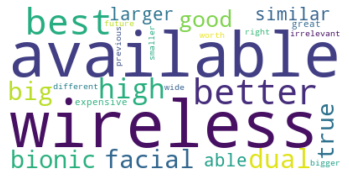

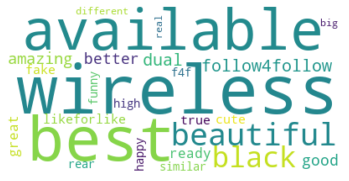

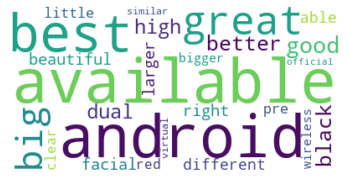

In [9]:
for i in range(len(combined_adjs)):
    text = " ".join(str(review) for review in combined_adjs[i] if not any(word in str(review) for word in del_words))
    wordcloud = WordCloud(background_color="white", collocations=False, max_words=25).generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [10]:
#preparing data for senti analysis


combined_Set = [iphone_x, iphone_8, galaxy]
combined_corpus = []
for i in combined_Set:
    token_data = i['tokenizedData']
    corpus = []
    for filler in token_data:
        corpus.append(nlp(filler))
    combined_corpus.append(corpus)

iphone_x["corpus"] = combined_corpus[0]
iphone_8["corpus"] = combined_corpus[1]
galaxy["corpus"] = combined_corpus[2]

In [11]:
iphone_x["corpus"] 

899       (free, iphone, iphone, apple, watch, series, m...
1197      (iphone, plus, better, iphonex, technology, wh...
1385                              (hmm, iphone, xq4mzxgzub)
1792      (iphone, plus, review, roundup, solid, upgrade...
1952      (iphone, month, iphone, month, #, iphonex, #, ...
                                ...                        
480345    (radarthekat, said, fallenjt, said, infinitybo...
483712    (crowley, said, radarthekat, said, fallenjt, s...
487794    (decade, iphone, unveiled, apple, going, reinv...
491728    (having, spent, billions, dollars, original, c...
504118    (new, rendersof, design, iphone, postedon, chi...
Name: corpus, Length: 2360, dtype: object

In [12]:
#lemmatiztion commented for now. As I think it is not needed in senti analysis
# def lemma(corpus):
#     lemmatizedData = []
#     for i in range(len(corpus)):
#         value =[]
#         for data in corpus[i]:
#             value.append(("").join(data.lemma_))
#         lemmatizedData.append(value)
#     return lemmatizedData
# combined_lemma = []
# for i in combined_corpus:
#     token_data = i
#     combined_lemma.append(lemma(token_data))

In [13]:
#performing sentiment analysis using vader
  
sentimentAnalyser = SentimentIntensityAnalyzer()

polarity_combined = []
for corpus in combined_corpus:
    polarity = []
    for values in corpus:
        polarity.append(sentimentAnalyser.polarity_scores(values.text))
    polarity_combined.append(polarity)


In [14]:
# extracting polarity compund scores
combined_compound = []
for i in polarity_combined:
    compoundValues = []
    for data in i:
        compoundValues.append(data.get("compound"))
    combined_compound.append(compoundValues)

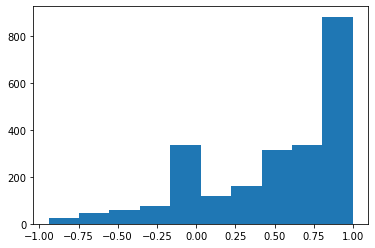

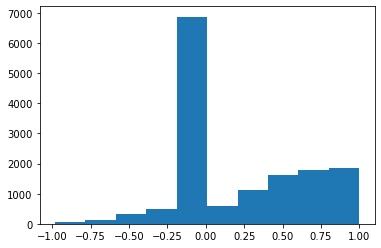

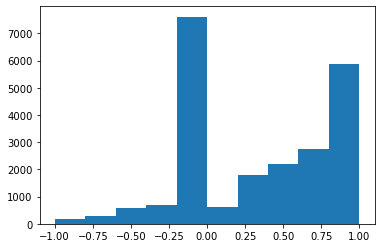

In [15]:

for i in range(len(combined_compound)):
    plt.figure()
    plt.hist(combined_compound[i])
    plt.show

In [130]:
#finding frequent words for highly poistive sentiments
pos_sent_combined = []
most_common_combined = []
for i in range(len(combined_compound)):
    pos_senti = []
    for j in range(len(combined_compound[i])):
        if combined_compound[i][j]>0.75:
            review = str(combined_corpus[i][j])
#             print(review)
            pos_senti.append(review)
    pos_sent_combined.append((" ".join(pos_senti).split()))
    most_common_combined.append(Counter(pos_sent_combined[i]).most_common(10))

        

In [135]:
# getting top 5 words for each phone
top = 5
top_words_combined = []
for i in range (len(most_common_combined)):
    top_words = []
    for j in range(top):
        word, count = most_common_combined[i][j]
        top_words.append(word)
    top_words_combined.append(top_words)


In [161]:
#creating dataframes for average polarity score calulation for the top positive words for each mobile
df_iphnx = pd.DataFrame(list(zip(combined_corpus[0], combined_compound[0])), columns =['Review', 'Polarity'])
df_iphn8 = pd.DataFrame(list(zip(combined_corpus[1], combined_compound[1])), columns =['Review', 'Polarity'])
df_galaxy = pd.DataFrame(list(zip(combined_corpus[2], combined_compound[2])), columns =['Review', 'Polarity'])

avgscoring_combined = [df_iphnx, df_iphn8, df_galaxy]

In [168]:
#calculating avergae polarity scores for each of the top words
for num in range(len(avgscoring_combined)):
    for i in top_words_combined[num]:
        avgscoring_combined[num][i] = 0 #creating a blank column for each of the top words.

    for i in avgscoring_combined[num].index: #looping over each datasets index to calucalte mean
        for word in top_words_combined[num]:
            if word in str(avgscoring_combined[num].loc[i]["Review"]):
                avgscoring_combined[num][word].loc[i] = 1 #populating column "word" if word is fiund in record index "i"
            

In [170]:
phone_order= ["iphone x", "iphone 8", "galaxy"]

for num in range(len(avgscoring_combined)):
    for i in top_words_combined[num]:
        print("For ", phone_order[num] ," for top word ", i, " the avergae senti score is: ", round(avgscoring_combined[num][avgscoring_combined[num][i]==1]["Polarity"].mean(), 2))

For  iphone x  for top word  iphone  the avergae senti score is:  0.5
For  iphone x  for top word  plus  the avergae senti score is:  0.58
For  iphone x  for top word  apple  the avergae senti score is:  0.54
For  iphone x  for top word  new  the avergae senti score is:  0.58
For  iphone x  for top word  ...  the avergae senti score is:  0.68
For  iphone 8  for top word  iphone  the avergae senti score is:  0.25
For  iphone 8  for top word  apple  the avergae senti score is:  0.24
For  iphone 8  for top word  plus  the avergae senti score is:  0.26
For  iphone 8  for top word  new  the avergae senti score is:  0.34
For  iphone 8  for top word  camera  the avergae senti score is:  0.43
For  galaxy  for top word  galaxy  the avergae senti score is:  0.37
For  galaxy  for top word  samsung  the avergae senti score is:  0.39
For  galaxy  for top word  phone  the avergae senti score is:  0.47
For  galaxy  for top word  new  the avergae senti score is:  0.53
For  galaxy  for top word  screen

In [ ]:
combined_corpus_bk = combined_corpus.copy()

In [19]:
#performing lemmatization for topic modelling

# iphone_x = iphone_x.sample(200)
# iphone_8 = iphone_8.sample(1000)
# galaxy = galaxy.sample(1000)

#took smaller samples for faster processing
#remove combined_corpus_new.
#For final analysis use combined_corpus
import random
combined_corpus_new = [None for _ in range(3)] # for testing to be deleted
combined_corpus_new[0] = random.sample(combined_corpus[0], 200)
combined_corpus_new[1] = random.sample(combined_corpus[1], 2000)
combined_corpus_new[2] = random.sample(combined_corpus[2], 2000)

def lemma(corpus):
    lemmatizedData = []
    for i in range(len(corpus)):
        value =[]
        for data in corpus[i]:
            value.append(("").join(data.lemma_))
        lemmatizedData.append(value)
    return lemmatizedData


combined_lemma = []
for i in combined_corpus_new: #change to combined_corpus
    token_data = i
    combined_lemma.append(lemma(token_data))

In [90]:
#performing topic modeling

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

#removing words which appear in topic modelling and are not useful
del_words = [".", "-" "\\n","...", "-", "come", "you", "be", "like", "user", "s8s", "galaxys8", "not"
             , "iphone8", "iphone8plus", "samsung", "#", "latest", "free", "mobile","iphone", "galaxy"
             , "samsung", "plus", "apple", "new", "phone", "device", "smartphone", "year", "model", "google", "note"]

#https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
#https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb
from pprint import pprint
topics_combined = []
for i in range(len(combined_lemma)):
    texts = combined_lemma[i]
    texts_1=[]
    for sent in texts:
        comb =[]
        text = [word for word in sent if word.lower() not in del_words]
        texts_1.append(text)
    dictionary = corpora.Dictionary(texts_1)
    bow_corpus = [dictionary.doc2bow(text) for text in texts_1]   
    # number of topics
    num_topics = 20
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics)
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    topics_combined.append(lda_model.print_topics())
# doc_lda = lda_model[bow_corpus]

[(0,
  '0.013*"\'s" + 0.009*"wireless" + 0.009*"camera" + 0.007*"charge" + '
  '0.007*"feature" + 0.006*"glass" + 0.006*"design" + 0.005*"inch" + '
  '0.005*"screen" + 0.005*"price"'),
 (1,
  '0.011*"wireless" + 0.011*"battery" + 0.010*"screen" + 0.010*"\'s" + '
  '0.009*"charge" + 0.009*"camera" + 0.007*"technology" + 0.006*"feature" + '
  '0.005*"glass" + 0.005*"design"'),
 (2,
  '0.009*"camera" + 0.009*"time" + 0.007*"start" + 0.007*"order" + 0.007*"\'s" '
  '+ 0.007*"release" + 0.006*"launch" + 0.005*"feature" + 0.005*"watch" + '
  '0.005*"analyst"'),
 (3,
  '0.019*"\'s" + 0.009*"wireless" + 0.009*"september" + 0.009*"upgrade" + '
  '0.009*"charge" + 0.008*"pre" + 0.007*"program" + 0.006*"watch" + '
  '0.006*"order" + 0.006*"feature"'),
 (4,
  '0.023*"case" + 0.015*"screen" + 0.011*"\'s" + 0.008*"charge" + 0.007*"inch" '
  '+ 0.006*"to" + 0.006*"percent" + 0.005*"view" + 0.005*"price" + 0.005*"it"'),
 (5,
  '0.010*"price" + 0.010*"\'s" + 0.009*"it" + 0.007*"good" + 0.006*"high" + '